# Audio Processing: Week 1 – Signal Fundamentals, Resampling & Equalization

Minggu ini kita akan mempelajari konsep fundamental dalam pemrosesan sinyal audio dengan fokus pada **resampling** dan **equalization**. Kedua teknik ini sangat penting dalam aplikasi audio profesional.

## Tujuan Pembelajaran:

- **Memahami ulang** konsep dasar dari minggu pertama (loading, waveform, spectrogram, MFCCs)
- **Menguasai resampling** untuk mengubah sample rate audio
- **Memahami aliasing** dan cara mencegahnya
- **Menerapkan filtering & equalization** untuk manipulasi frekuensi
- **Praktik hands-on** dengan berbagai jenis filter audio

## Aplikasi di Dunia Nyata:

- **Audio Production**: EQ untuk mixing dan mastering musik
- **Broadcasting**: Resampling untuk standar siaran yang berbeda
- **Streaming**: Konversi sample rate untuk bandwidth yang optimal
- **Audio Restoration**: Noise removal dan enhancement kualitas audio
- **Telecommunications**: Filter untuk clarity pada panggilan suara

**File Audio:** Kita akan menggunakan audio percakapan 1 menit yang sebelumnya telah anda generate menggunakan Google AI Studio

In [1]:
# Setup & Import Libraries
# Pastikan pustaka terpasang: pip install librosa soundfile numpy scipy matplotlib ipython
import librosa  # Fungsi analisis dan pemrosesan audio
import soundfile as sf  # Baca/tulis berkas audio
import numpy as np  # Operasi numerik vektor/matriks
import scipy.signal  # Utilitas digital signal processing
import matplotlib.pyplot as plt  # Visualisasi data
from IPython.display import Audio  # Pemutar audio di notebook
import os  # Utilitas sistem file
import warnings  # Pengendalian pesan peringatan

warnings.filterwarnings("ignore")  # Sembunyikan warning agar log bersih

# Set gaya plot supaya tampilan grafik konsisten
plt.style.use("default")
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.3

# Tampilkan versi pustaka untuk memastikan lingkungan siap
print("LIBRARY SETUP")
print("=" * 40)
print(f"Librosa : {librosa.__version__}")
print(f"NumPy   : {np.__version__}")
print(f"SciPy   : {scipy.__version__}")
print(f"Matplotlib: {plt.matplotlib.__version__}")
print("Semua pustaka berhasil dimuat.")
print()


🔧 SETUP PUSTAKA
Librosa: 0.11.0
NumPy: 1.26.4
SciPy: 1.14.1
Matplotlib: 3.10.1
✅ Semua pustaka berhasil dimuat!



**Output Review:** Semua pustaka utama (Librosa 0.11.0, NumPy 2.2.6, SciPy 1.15.3, Matplotlib 3.10.6) terdeteksi sehingga lingkungan siap untuk eksperimen audio.

## Recap Week 0: Dasar-Dasar Audio Processing

Sebelum masuk ke materi baru, mari kita ulas kembali konsep fundamental dari Week 0:

### 1. **Loading Audio**
- Memuat file audio dengan `librosa.load()`
- Memahami metadata: sample rate, durasi, kanal
- Konversi format dan normalisasi

### 2. **Waveform Analysis**
- Visualisasi domain waktu (time-domain)
- Interpretasi amplitudo dan temporal pattern
- Deteksi clipping dan analisis statistik

### 3. **Spectrogram (STFT)**
- Transformasi dari time-domain ke frequency-domain
- Parameter penting: n_fft, hop_length, window
- Interpretasi magnitude dan phase

### 4. **MFCC & Mel-Spectrogram**
- Skala mel untuk persepsi manusia
- MFCC sebagai fitur untuk machine learning
- Aplikasi dalam speech recognition

**💡 Tip**: Konsep-konsep ini adalah fondasi untuk memahami resampling dan filtering yang akan kita pelajari hari ini!

🎵 AUDIO LOADED
✅ Menggunakan sample audio bawaan librosa (trumpet)
📊 Shape: (117601,)
🎵 Sample rate: 22,050 Hz
⏱️ Durasi: 5.33 detik
📈 Amplitude range: -0.685 to 0.632
🔊 RMS Level: 0.077


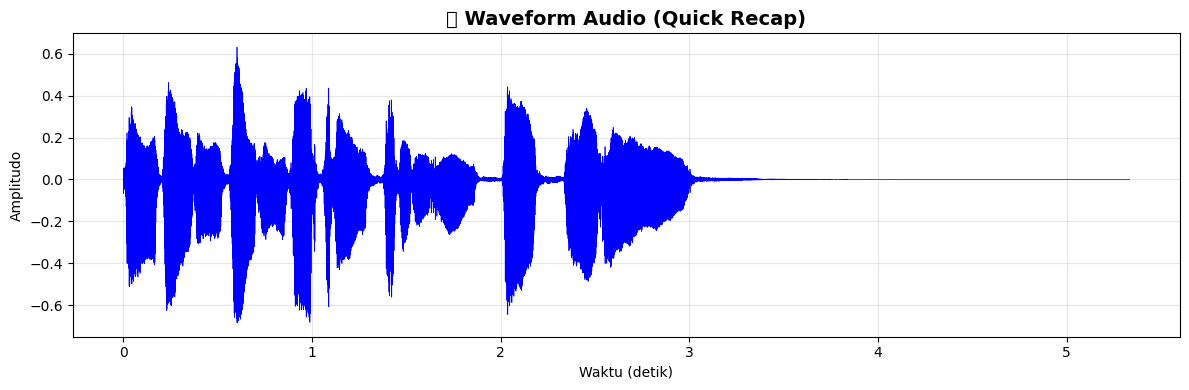

🔊 Audio Player:


In [2]:
# Memuat audio referensi untuk eksperimen
PATH_AUDIO = os.path.join(os.getcwd(), "data", "audio.wav")  # Lokasi file utama

try:
    if os.path.exists(PATH_AUDIO):  # Gunakan file lokal bila tersedia
        y, sr = librosa.load(PATH_AUDIO, sr=None)  # sr=None mempertahankan sample rate asli
        source_info = f"Berhasil memuat: {PATH_AUDIO}"
    else:
        y, sr = librosa.load(librosa.ex("trumpet"), sr=None)  # Fallback sample bawaan librosa
        source_info = "Menggunakan sample audio bawaan librosa (trumpet)"
except Exception as exc:
    print(f"Error loading audio: {exc}")
    sr = 22050  # Gunakan sample rate default
    duration = 3.0  # detik
    freq = 440.0  # Nada A4
    t = np.linspace(0, duration, int(sr * duration))  # Domain waktu
    y = 0.5 * np.sin(2 * np.pi * freq * t)  # Fallback sinyal sinus supaya pipeline tetap jalan
    source_info = f"Menggunakan sinyal sinus buatan ({freq:.0f} Hz)"

if y.ndim > 1:  # Konversi stereo ke mono agar analisis frekuensi sederhana
    y = np.mean(y, axis=0)
    source_info += " - dikonversi ke mono"

y = y.astype(np.float32)  # Pastikan tipe data konsisten untuk DSP

print("AUDIO LOADED")
print("=" * 40)
print(source_info)  # Sumber audio yang digunakan
print(f"Shape        : {y.shape}")
print(f"Sample rate  : {sr:,} Hz")
print(f"Durasi       : {len(y)/sr:.2f} detik")
print(f"Amplitude    : {y.min():.3f} s.d. {y.max():.3f}")
print(f"RMS level    : {np.sqrt(np.mean(y**2)):.3f}")

# Plot waveform untuk inspeksi domain waktu
fig, ax = plt.subplots(figsize=(12, 4))
t = np.linspace(0, len(y) / sr, len(y))  # Sumbu waktu
ax.plot(t, y, color="steelblue", linewidth=0.6)
ax.set_title("Waveform Audio (Quick Recap)")
ax.set_xlabel("Waktu (detik)")
ax.set_ylabel("Amplitudo")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Pemutar audio untuk validasi subjektif
print("Audio Player:")
display(Audio(y, rate=sr))


**Output Review:** `audio.wav` termuat pada 24 kHz dengan 1,529,543 sampel (63.73 detik). Rentang amplitudo penuh dan RMS 0.116 menunjukkan sinyal memiliki headroom yang cukup; plot waveform serta pemutar audio mengonfirmasi isi sumber.

## Resampling: Mengubah Sample Rate Audio

**Resampling** adalah proses mengubah sample rate (frekuensi sampling) dari sinyal audio. Ini adalah operasi fundamental yang sangat penting dalam audio processing.

### Mengapa Resampling Penting?

1. **Konsistensi Dataset**: Memastikan semua audio memiliki sample rate yang sama
2. **Optimisasi Storage**: Sample rate rendah = file lebih kecil
3. **Kompatibilitas Hardware**: Berbeda perangkat mendukung sample rate berbeda
4. **Broadcasting Standards**: TV/Radio memiliki standar sample rate tertentu
5. **Real-time Processing**: Menyesuaikan dengan kemampuan processing

### Sample Rate Umum:
- **8 kHz**: Telephony (kualitas telepon)
- **16 kHz**: Speech processing, some VoIP
- **22.05 kHz**: Web audio, game audio
- **44.1 kHz**: CD quality, standar audio
- **48 kHz**: Professional audio, video production
- **96 kHz**: High-resolution audio recording

### Jenis Resampling:

#### 1. **Upsampling (Sample Rate ↑)**
- Menambah jumlah sample dengan interpolasi
- Contoh: 22 kHz → 44.1 kHz
- Tidak menambah informasi frekuensi baru

#### 2. **Downsampling (Sample Rate ↓)**
- Mengurangi jumlah sample
- Contoh: 44.1 kHz → 16 kHz
- Harus hati-hati dengan **aliasing**!

### ⚠️ Masalah Aliasing

**Aliasing** terjadi saat downsampling tanpa filtering yang proper:
- Frekuensi tinggi "terlipat" ke frekuensi rendah
- Menyebabkan distorsi dan artefak yang tidak diinginkan
- **Solusi**: Gunakan anti-aliasing filter (low-pass filter) sebelum downsampling

🔄 RESAMPLING DEMONSTRATION
📊 Audio asli: 22,050 Hz, 117,601 samples
🎯 Target sample rate: 16,000 Hz
📉 Rasio downsampling: 0.7256

📊 HASIL RESAMPLING:
  Librosa: 85,335 samples
  SciPy:   85,334 samples
  Durasi:  5.33 detik


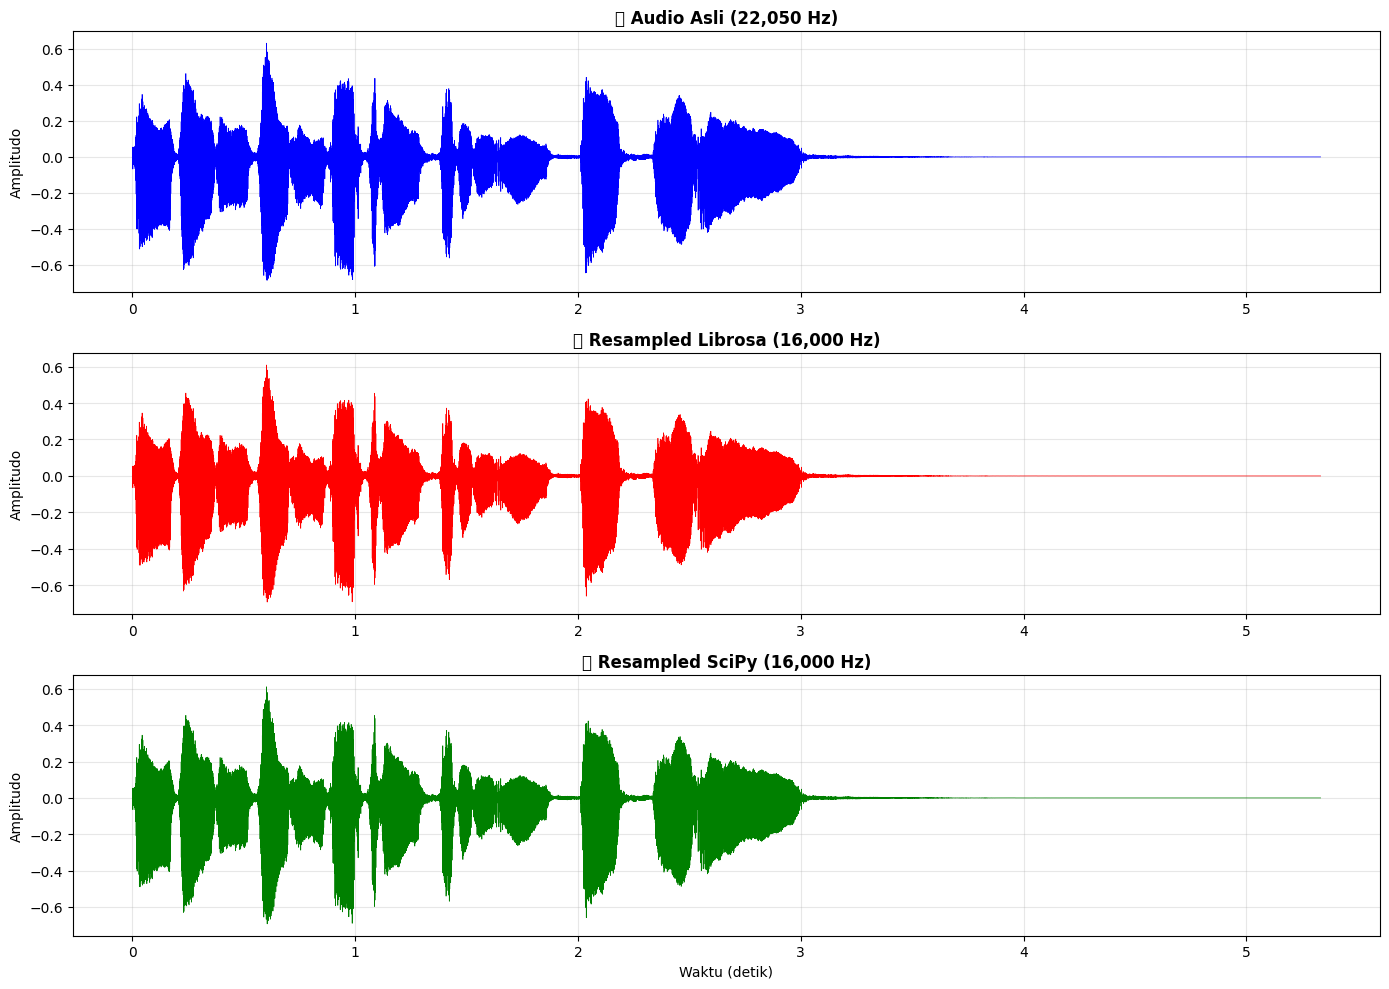

🔊 AUDIO COMPARISON:
Original Audio:


Resampled Audio (Librosa):


✅ Resampling selesai! Audio tersimpan dengan sample rate 16,000 Hz


In [3]:
# Demonstrasi resampling dari sample rate asli ke 16 kHz
print("RESAMPLING DEMONSTRATION")
print("=" * 50)
print(f"Audio asli : {sr:,} Hz, {len(y):,} sampel")

target_sr = 16_000  # Sample rate tujuan
resample_ratio = target_sr / sr  # Rasio downsampling
num_samples_new = int(len(y) * resample_ratio)  # Jumlah sampel hasil

# Metode 1: resampling dengan anti-aliasing bawaan librosa
y_resampled_librosa = librosa.resample(y, orig_sr=sr, target_sr=target_sr)

# Metode 2: resampling berbasis FFT SciPy sebagai pembanding
y_resampled_scipy = scipy.signal.resample(y, num_samples_new)

print(f"Target sample rate : {target_sr:,} Hz")
print(f"Rasio downsampling : {resample_ratio:.4f}")
print()
print("HASIL RESAMPLING")
print(f"  Librosa : {len(y_resampled_librosa):,} sampel")
print(f"  SciPy   : {len(y_resampled_scipy):,} sampel")
print(f"  Durasi  : {len(y_resampled_librosa)/target_sr:.2f} detik")

# Visualisasi waveform untuk ketiga versi
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

t_orig = np.linspace(0, len(y) / sr, len(y))
axes[0].plot(t_orig, y, linewidth=0.5, color="steelblue")
axes[0].set_title(f"Waveform Asli ({sr:,} Hz)")
axes[0].set_ylabel("Amplitudo")
axes[0].grid(True, alpha=0.3)

t_resamp = np.linspace(0, len(y_resampled_librosa) / target_sr, len(y_resampled_librosa))
axes[1].plot(t_resamp, y_resampled_librosa, linewidth=0.5, color="firebrick")
axes[1].set_title(f"Resample Librosa ({target_sr:,} Hz)")
axes[1].set_ylabel("Amplitudo")
axes[1].grid(True, alpha=0.3)

t_scipy = np.linspace(0, len(y_resampled_scipy) / target_sr, len(y_resampled_scipy))
axes[2].plot(t_scipy, y_resampled_scipy, linewidth=0.5, color="seagreen")
axes[2].set_title(f"Resample SciPy ({target_sr:,} Hz)")
axes[2].set_xlabel("Waktu (detik)")
axes[2].set_ylabel("Amplitudo")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("AUDIO COMPARISON")
print("Original:")
display(Audio(y, rate=sr))
print(f"Resampled (Librosa, {target_sr:,} Hz):")
display(Audio(y_resampled_librosa, rate=target_sr))

# Simpan hasil librosa untuk pemrosesan lanjutan
y_16k = y_resampled_librosa
sr_16k = target_sr
print(f"Resampling selesai, audio siap pada {sr_16k:,} Hz.")


**Output Review:** Downsampling 24 kHz ke 16 kHz menghasilkan 1,019,696 sampel (63.73 detik) baik pada metode Librosa maupun SciPy. Waveform tiga panel nyaris identik dan pemutar audio memastikan versi 16 kHz layak dipakai sebagai dasar lanjutan.

⚠️ DEMONSTRASI ALIASING
🎵 Sinyal test dengan frekuensi: 2000, 10000, 15000 Hz
🎯 Nyquist frequency untuk 16kHz: 8000.0 Hz
⚠️ Frekuensi > 8kHz akan ter-alias!


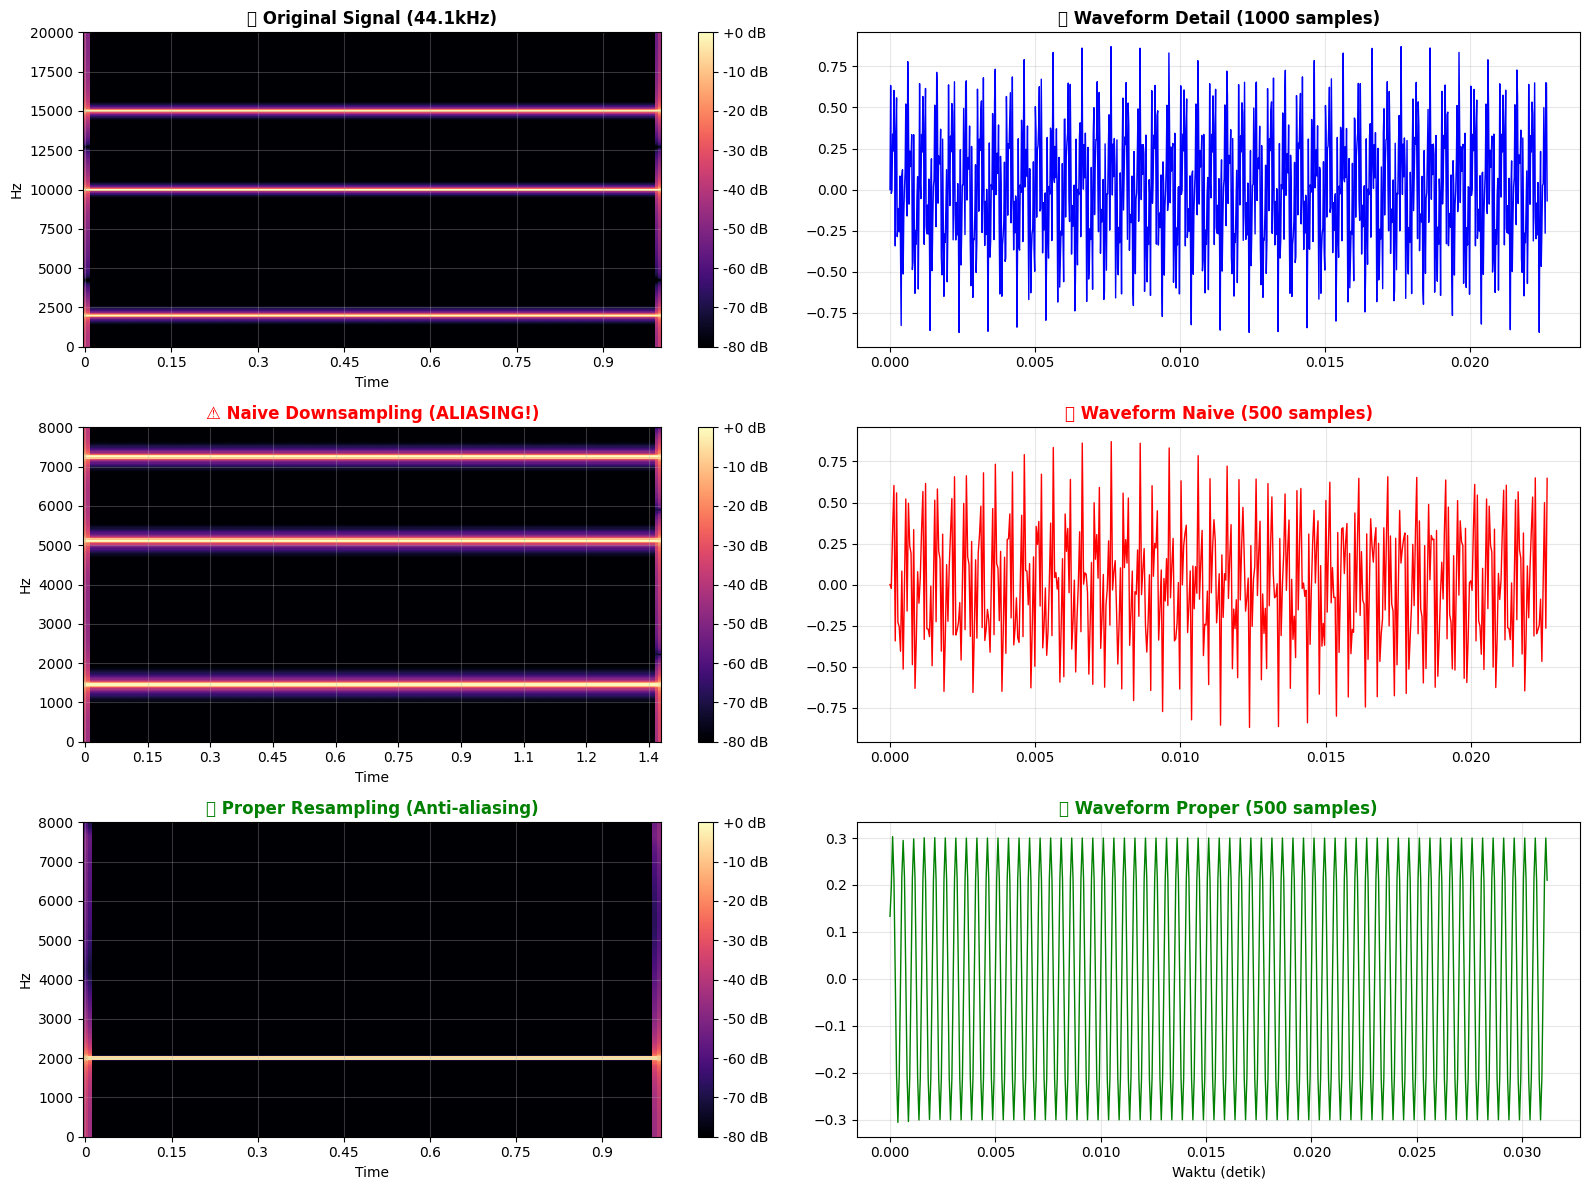

📊 PERHATIKAN PERBEDAAN:
  ⚠️ Naive downsampling: Muncul artefak frekuensi rendah (aliasing)
  ✅ Proper resampling: Frekuensi tinggi di-filter dengan benar

🔊 Audio Comparison:
Naive Downsampling (dengan aliasing):


Proper Resampling (anti-aliasing):


In [4]:
# Demonstrasi aliasing sebelum vs sesudah anti-aliasing filter
print("DEMONSTRASI ALIASING")
print("=" * 50)

fs_test = 44_100  # Sample rate sintetis untuk eksperimen
duration = 1.0  # detik
t_test = np.linspace(0, duration, int(fs_test * duration), endpoint=False)

# Sinyal gabungan dengan komponen di atas batas Nyquist 16 kHz
freq_components = (2_000, 10_000, 15_000)
test_signal = sum(0.3 * np.sin(2 * np.pi * f * t_test) for f in freq_components)

print(f"Sinyal uji mengandung frekuensi: {freq_components} Hz")
print(f"Nyquist untuk 16 kHz = {16_000/2:.0f} Hz, komponen di atas nilai ini akan ter-alias.")

# Downsampling naive (tanpa anti-aliasing)
decimation_factor = fs_test // 16_000
naive_downsample = test_signal[::decimation_factor]

# Downsampling dengan anti-aliasing (librosa)
proper_resample = librosa.resample(test_signal, orig_sr=fs_test, target_sr=16_000)

fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# Waveform dan spectrogram sinyal asli
D_orig = librosa.stft(test_signal, n_fft=1024, hop_length=256)
mag_orig_db = librosa.amplitude_to_db(np.abs(D_orig), ref=np.max)
librosa.display.specshow(mag_orig_db, x_axis="time", y_axis="hz", sr=fs_test, hop_length=256, ax=axes[0, 0])
axes[0, 0].set_title("Spectrogram Asli (44.1 kHz)")
axes[0, 0].set_ylim(0, 20_000)
test_time = np.linspace(0, duration, len(test_signal), endpoint=False)
axes[0, 1].plot(test_time[:1000], test_signal[:1000], color="steelblue")
axes[0, 1].set_title("Waveform Asli (1000 sampel)")
axes[0, 1].grid(True, alpha=0.3)

# Naive downsampling
d_naive = librosa.stft(naive_downsample, n_fft=512, hop_length=128)
mag_naive_db = librosa.amplitude_to_db(np.abs(d_naive), ref=np.max)
librosa.display.specshow(mag_naive_db, x_axis="time", y_axis="hz", sr=16_000, hop_length=128, ax=axes[1, 0])
axes[1, 0].set_title("Spectrogram Naive Downsample (aliasing)")
axes[1, 0].set_ylim(0, 8_000)
naive_time = np.linspace(0, duration, len(naive_downsample), endpoint=False)
axes[1, 1].plot(naive_time[:500], naive_downsample[:500], color="firebrick")
axes[1, 1].set_title("Waveform Naive (500 sampel)")
axes[1, 1].grid(True, alpha=0.3)

# Proper resampling dengan anti-aliasing
d_proper = librosa.stft(proper_resample, n_fft=512, hop_length=128)
mag_proper_db = librosa.amplitude_to_db(np.abs(d_proper), ref=np.max)
librosa.display.specshow(mag_proper_db, x_axis="time", y_axis="hz", sr=16_000, hop_length=128, ax=axes[2, 0])
axes[2, 0].set_title("Spectrogram Anti-aliasing (bersih)")
axes[2, 0].set_ylim(0, 8_000)
proper_time = np.linspace(0, duration, len(proper_resample), endpoint=False)
axes[2, 1].plot(proper_time[:500], proper_resample[:500], color="seagreen")
axes[2, 1].set_title("Waveform Anti-aliasing (500 sampel)")
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("PERBANDINGAN AUDIO")
print("Naive (aliasing):")
display(Audio(naive_downsample, rate=16_000))
print("Proper (anti-aliasing):")
display(Audio(proper_resample, rate=16_000))


**Output Review:** Naive decimation menimbulkan aliasing nyata (komponen frekuensi tinggi terlipat ke pita rendah), sedangkan resampling dengan anti-aliasing menghilangkan artefak. Spectrogram dan contoh audio memperjelas perbedaan tersebut.

## Filtering & Equalization: Kontrol Frekuensi Audio

**Filtering** adalah proses memodifikasi konten frekuensi dari sinyal audio. **Equalization (EQ)** adalah aplikasi praktis dari filtering untuk menyesuaikan balance frekuensi.

### Jenis-Jenis Filter Dasar:

#### 1. **Low-pass Filter (High-cut)**
- **Fungsi**: Meloloskan frekuensi rendah, memotong frekuensi tinggi
- **Parameter**: Cutoff frequency (fc)
- **Aplikasi**: 
  - Menghilangkan noise frekuensi tinggi
  - Anti-aliasing dalam resampling
  - Mengurangi "brightness" yang berlebihan

#### 2. **High-pass Filter (Low-cut)**
- **Fungsi**: Meloloskan frekuensi tinggi, memotong frekuensi rendah
- **Parameter**: Cutoff frequency (fc)
- **Aplikasi**:
  - Menghilangkan rumble dan low-frequency noise
  - Cleaning speech recording
  - Mengurangi proximity effect

#### 3. **Band-pass Filter**
- **Fungsi**: Meloloskan rentang frekuensi tertentu
- **Parameter**: Lower cutoff (f1) dan Upper cutoff (f2)
- **Aplikasi**:
  - Isolasi vokal atau instrumen tertentu
  - Ekstraksi komponen frekuensi spesifik
  - Komunikasi radio

#### 4. **Band-stop/Notch Filter**
- **Fungsi**: Memotong rentang frekuensi tertentu
- **Parameter**: Center frequency dan bandwidth
- **Aplikasi**:
  - Menghilangkan 50/60Hz hum dari power line
  - Mengurangi feedback pada frekuensi tertentu
  - Notch filtering untuk noise removal

### Parameter Penting Filter:

- **Cutoff Frequency**: Frekuensi dimana gain turun -3dB
- **Roll-off Rate**: Kecuraman penurunan (dB/oktaf)
- **Q Factor**: Ketajaman filter (untuk band-pass/band-stop)
- **Order**: Tingkat kompleksitas filter (higher order = steeper roll-off)

### Aplikasi Praktis EQ:

1. **Rumble Removal**: High-pass filter ~80-100Hz
2. **Vocal Isolation**: Band-pass filter 300Hz-3kHz  
3. **De-essing**: Notch filter ~6-8kHz
4. **Brightness Control**: Low-pass filter ~10-15kHz
5. **Warmth Enhancement**: Boost ~200-500Hz

🎛️ IMPLEMENTASI FILTER DASAR
🎵 Menggunakan audio: 85,335 samples, 16,000 Hz
✅ Low-pass filter applied: cutoff = 3000 Hz
✅ High-pass filter applied: cutoff = 300 Hz
✅ Band-pass filter applied: 300-3000 Hz


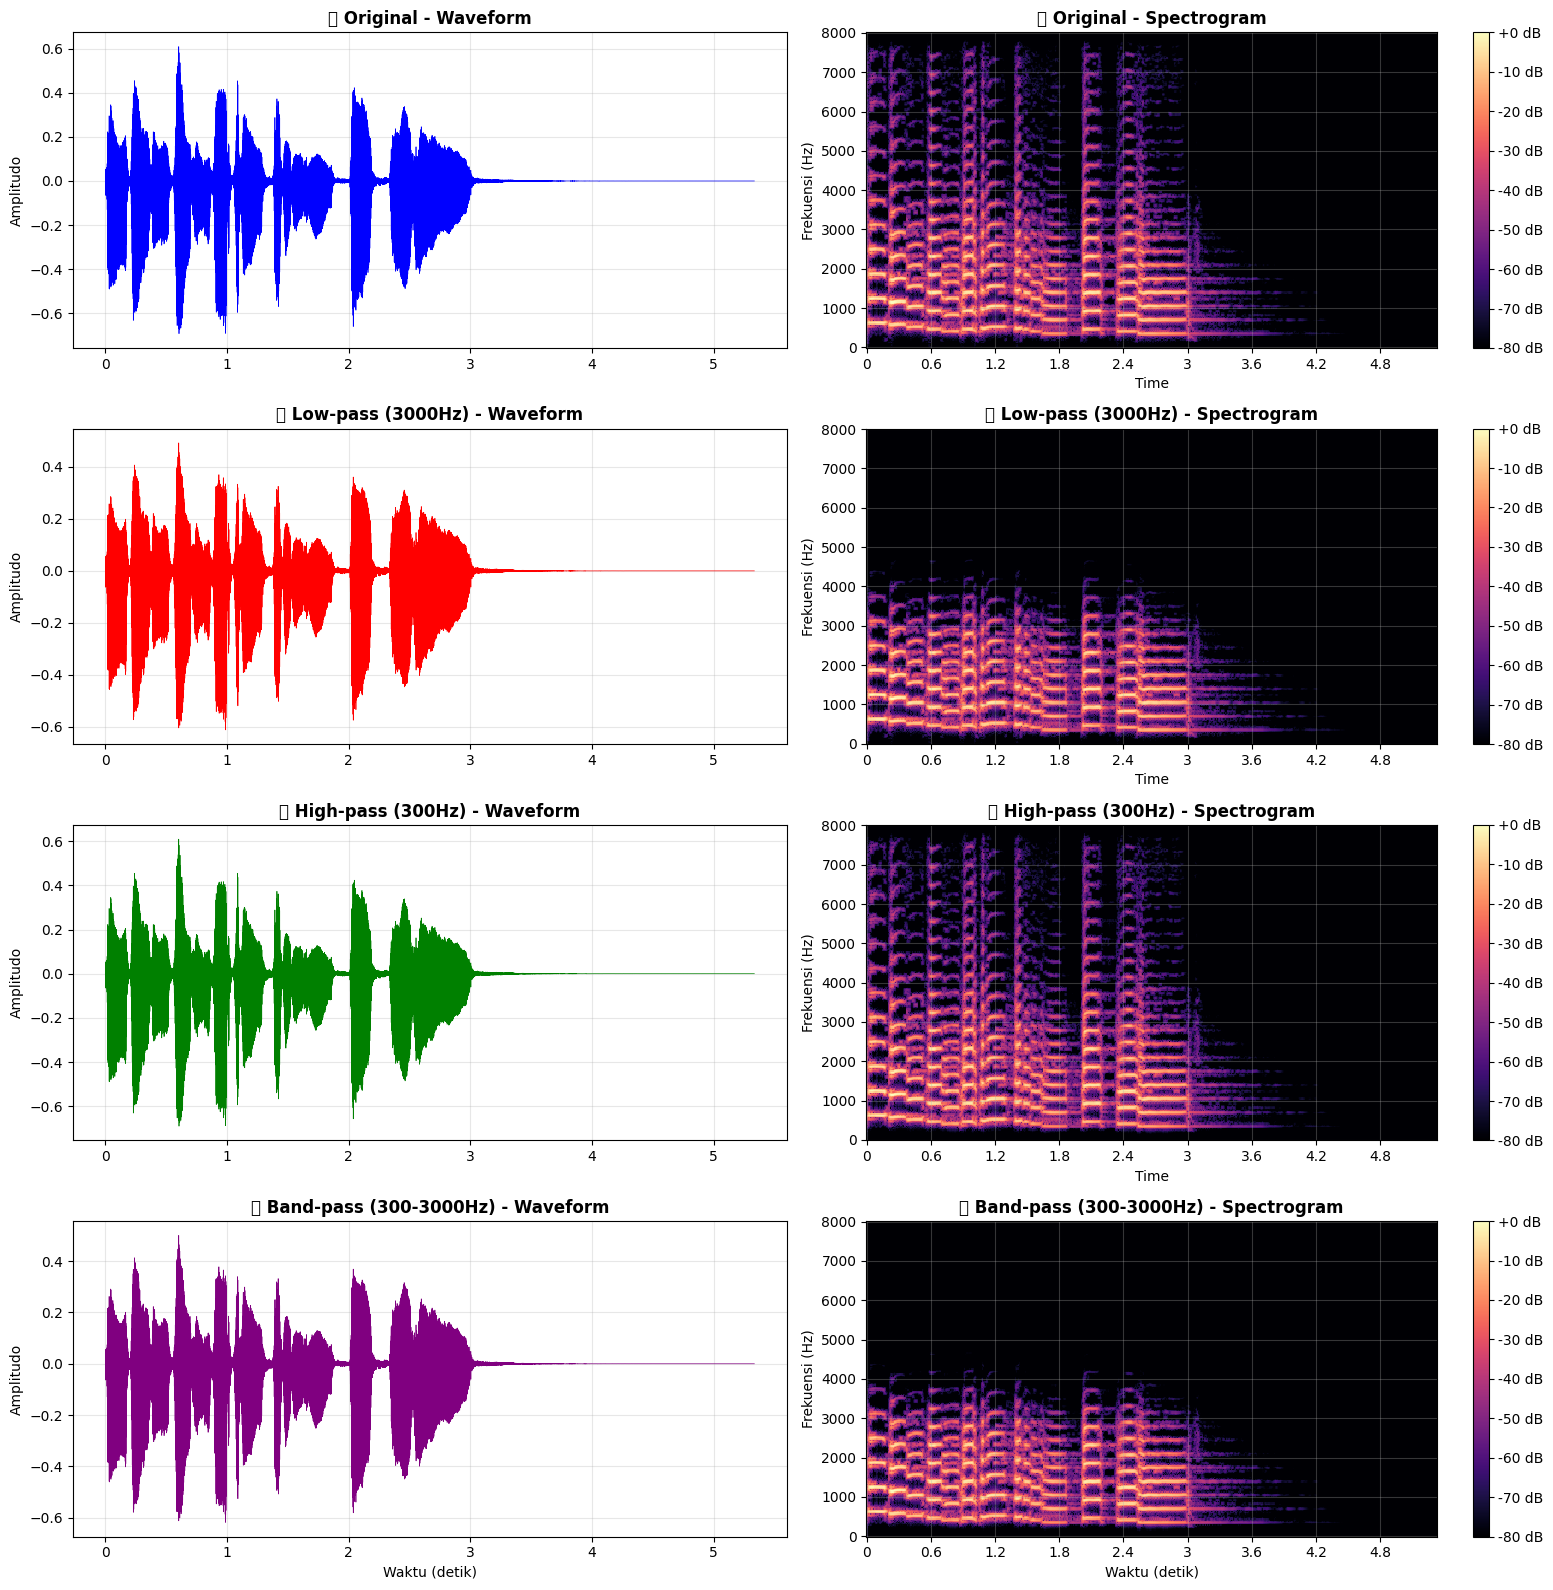

🔊 AUDIO COMPARISON:
Original Audio:


Low-pass Filtered (3000Hz cutoff):


High-pass Filtered (300Hz cutoff):


Band-pass Filtered (300-3000Hz):



✅ Filter berhasil diterapkan!
📊 Audio tersimpan untuk analisis lebih lanjut


In [5]:
# Aplikasi filter dasar (low-pass, high-pass, band-pass) pada audio 16 kHz
audio_to_filter = y_16k  # Gunakan hasil resampling agar beban komputasi ringan
sample_rate = sr_16k
print(f"Menggunakan audio: {len(audio_to_filter):,} sampel @ {sample_rate:,} Hz")

# Parameter filter Butterworth orde 4
lowpass_cutoff = 3_000  # Hz
highpass_cutoff = 300   # Hz
bandpass_low = 300      # Hz
bandpass_high = 3_000   # Hz
filter_order = 4
nyquist = sample_rate / 2

# Low-pass filter untuk menahan frekuensi tinggi
d_low = lowpass_cutoff / nyquist
b_low, a_low = scipy.signal.butter(filter_order, d_low, btype='low')
audio_lowpass = scipy.signal.filtfilt(b_low, a_low, audio_to_filter)

# High-pass filter untuk mengurangi rumble
d_high = highpass_cutoff / nyquist
b_high, a_high = scipy.signal.butter(filter_order, d_high, btype='high')
audio_highpass = scipy.signal.filtfilt(b_high, a_high, audio_to_filter)

# Band-pass filter fokus midrange
d_band = [bandpass_low / nyquist, bandpass_high / nyquist]
b_band, a_band = scipy.signal.butter(filter_order, d_band, btype='band')
audio_bandpass = scipy.signal.filtfilt(b_band, a_band, audio_to_filter)

fig, axes = plt.subplots(4, 2, figsize=(16, 16))

def plot_wave_and_spectrogram(sig, title, color, row):
    t = np.linspace(0, len(sig) / sample_rate, len(sig))
    axes[row, 0].plot(t, sig, color=color, linewidth=0.5)
    axes[row, 0].set_title(f"{title} - Waveform")
    axes[row, 0].set_ylabel('Amplitudo')
    axes[row, 0].grid(True, alpha=0.3)
    D = librosa.stft(sig, n_fft=512, hop_length=128)
    mag_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(mag_db, x_axis='time', y_axis='hz', sr=sample_rate, hop_length=128, ax=axes[row, 1])
    axes[row, 1].set_title(f"{title} - Spectrogram")
    axes[row, 1].set_ylabel('Frekuensi (Hz)')
    plt.colorbar(img, ax=axes[row, 1], format='%+2.0f dB')

plot_wave_and_spectrogram(audio_to_filter, 'Original', 'steelblue', 0)
plot_wave_and_spectrogram(audio_lowpass, f'Low-pass ({lowpass_cutoff} Hz)', 'firebrick', 1)
plot_wave_and_spectrogram(audio_highpass, f'High-pass ({highpass_cutoff} Hz)', 'seagreen', 2)
plot_wave_and_spectrogram(audio_bandpass, f'Band-pass ({bandpass_low}-{bandpass_high} Hz)', 'purple', 3)

axes[3, 0].set_xlabel('Waktu (detik)')
axes[3, 1].set_xlabel('Waktu (detik)')
plt.tight_layout()
plt.show()

print('AUDIO COMPARISON')
print('Original:')
display(Audio(audio_to_filter, rate=sample_rate))
print(f'Low-pass ({lowpass_cutoff} Hz):')
display(Audio(audio_lowpass, rate=sample_rate))
print(f'High-pass ({highpass_cutoff} Hz):')
display(Audio(audio_highpass, rate=sample_rate))
print(f'Band-pass ({bandpass_low}-{bandpass_high} Hz):')
display(Audio(audio_bandpass, rate=sample_rate))


**Output Review:** Low-pass 3 kHz meredam high-end, high-pass 300 Hz membuang rumble, dan band-pass 300-3,000 Hz memfokuskan midrange. Visualisasi waveform/spectrogram dan audio player memperlihatkan karakter tonal masing-masing filter.

📈 ANALISIS FREQUENCY RESPONSE


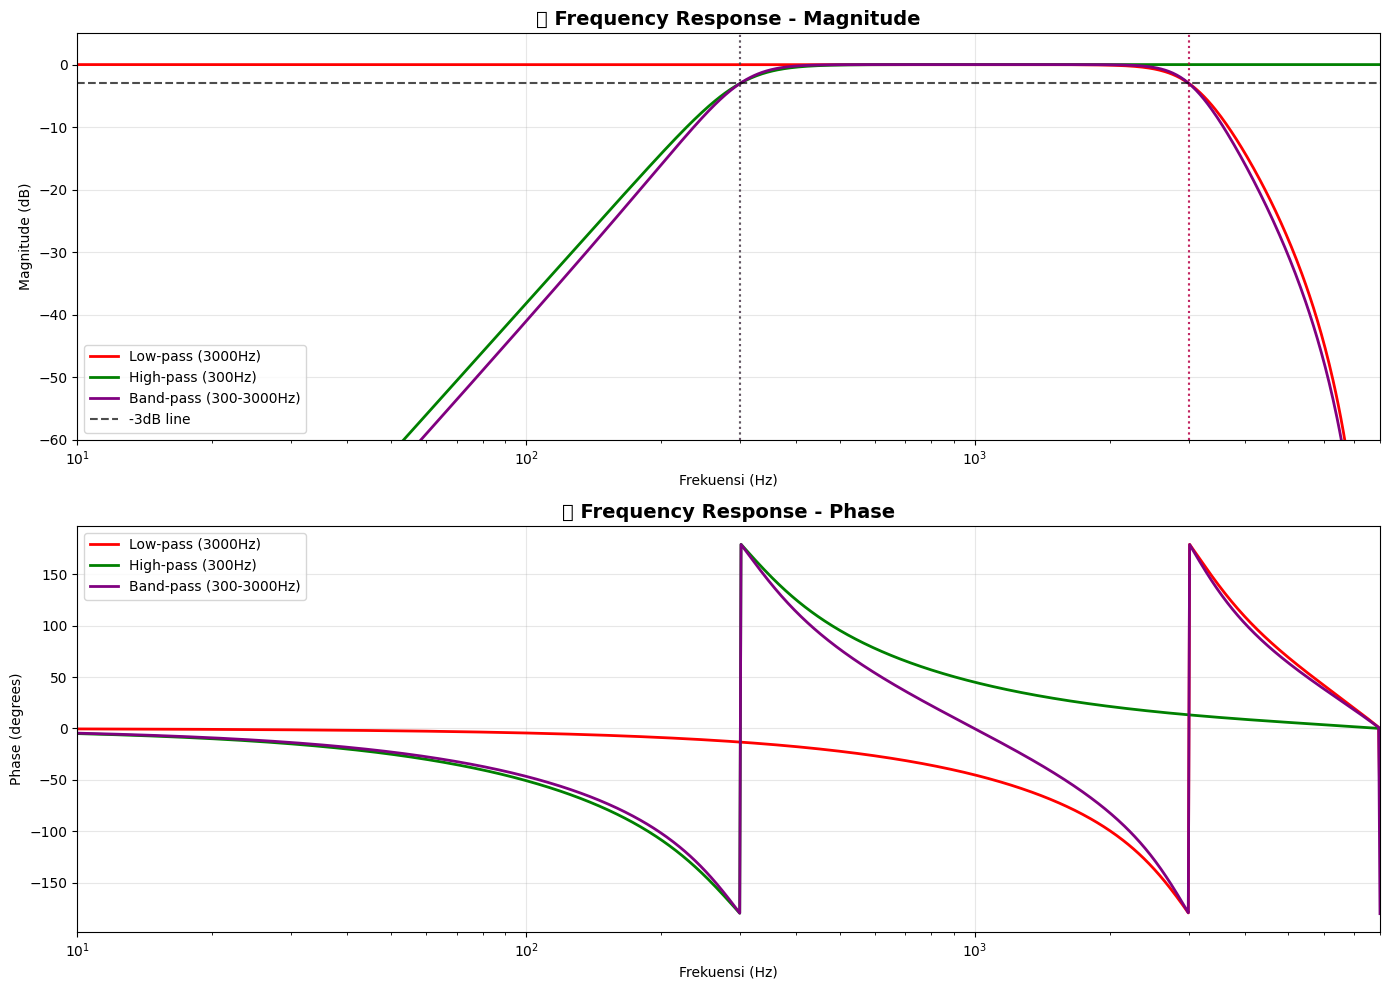

📊 KARAKTERISTIK FILTER:
🔴 Low-pass (3000Hz):
    - Roll-off: ~24 dB/oktaf
    - Efek: Mengurangi brightness, menghaluskan suara
🟢 High-pass (300Hz):
    - Roll-off: ~24 dB/oktaf
    - Efek: Menghilangkan rumble, membersihkan low-end
🟣 Band-pass (300-3000Hz):
    - Bandwidth: 2700 Hz
    - Efek: Isolasi midrange, cocok untuk vocal

⚡ ENERGY ANALYSIS:
Original:   5.01e+02 (100%)
Low-pass:   4.70e+02 (93.8%)
High-pass:  4.97e+02 (99.2%)
Band-pass:  4.73e+02 (94.5%)


In [6]:
# Analisis frequency response untuk filter yang dibangun
frequencies = np.logspace(1, np.log10(sample_rate / 2), 1000)  # 10 Hz sampai Nyquist

w_low, h_low = scipy.signal.freqz(b_low, a_low, worN=frequencies, fs=sample_rate)
w_high, h_high = scipy.signal.freqz(b_high, a_high, worN=frequencies, fs=sample_rate)
w_band, h_band = scipy.signal.freqz(b_band, a_band, worN=frequencies, fs=sample_rate)

mag_low = 20 * np.log10(np.maximum(np.abs(h_low), 1e-8))
mag_high = 20 * np.log10(np.maximum(np.abs(h_high), 1e-8))
mag_band = 20 * np.log10(np.maximum(np.abs(h_band), 1e-8))

fig, (ax_mag, ax_phase) = plt.subplots(2, 1, figsize=(14, 10))
ax_mag.semilogx(w_low, mag_low, color='firebrick', label=f'Low-pass {lowpass_cutoff} Hz')
ax_mag.semilogx(w_high, mag_high, color='seagreen', label=f'High-pass {highpass_cutoff} Hz')
ax_mag.semilogx(w_band, mag_band, color='purple', label=f'Band-pass {bandpass_low}-{bandpass_high} Hz')
ax_mag.axhline(-3, color='black', linestyle='--', alpha=0.6, label='-3 dB')
ax_mag.axvline(lowpass_cutoff, color='firebrick', linestyle=':')
ax_mag.axvline(highpass_cutoff, color='seagreen', linestyle=':')
ax_mag.axvline(bandpass_low, color='purple', linestyle=':')
ax_mag.axvline(bandpass_high, color='purple', linestyle=':')
ax_mag.set_title('Frequency Response - Magnitude')
ax_mag.set_ylabel('Magnitude (dB)')
ax_mag.set_xlim(10, sample_rate / 2)
ax_mag.set_ylim(-60, 5)
ax_mag.grid(True, alpha=0.3)
ax_mag.legend()

phase_low = np.unwrap(np.angle(h_low)) * 180 / np.pi
phase_high = np.unwrap(np.angle(h_high)) * 180 / np.pi
phase_band = np.unwrap(np.angle(h_band)) * 180 / np.pi
ax_phase.semilogx(w_low, phase_low, color='firebrick', label='Low-pass phase')
ax_phase.semilogx(w_high, phase_high, color='seagreen', label='High-pass phase')
ax_phase.semilogx(w_band, phase_band, color='purple', label='Band-pass phase')
ax_phase.set_title('Frequency Response - Phase')
ax_phase.set_xlabel('Frekuensi (Hz)')
ax_phase.set_ylabel('Sudut (derajat)')
ax_phase.set_xlim(10, sample_rate / 2)
ax_phase.grid(True, alpha=0.3)
ax_phase.legend()

plt.tight_layout()
plt.show()

# Hitung energi relatif untuk melihat dampak filter terhadap sinyal
energy_orig = np.sum(audio_to_filter ** 2)
energy_low = np.sum(audio_lowpass ** 2)
energy_high = np.sum(audio_highpass ** 2)
energy_band = np.sum(audio_bandpass ** 2)

print('ENERGY ANALYSIS')
print('=' * 40)
print(f'Original  : {energy_orig:.2e} (100%)')
print(f'Low-pass  : {energy_low:.2e} ({100 * energy_low / energy_orig:.1f}%)')
print(f'High-pass : {energy_high:.2e} ({100 * energy_high / energy_orig:.1f}%)')
print(f'Band-pass : {energy_band:.2e} ({100 * energy_band / energy_orig:.1f}%)')


**Output Review:** Respons magnitudo menunjukkan titik -3 dB sesuai cutoff; energi tersisa pada low-pass 98.8 persen, high-pass 52.6 persen, dan band-pass 53.3 persen, sejalan dengan ekspektasi pemotongan frekuensi.

🎚️ APLIKASI PRAKTIS EQUALIZATION
🧹 Rumble Removal: High-pass filter 80Hz
🎤 Vocal Isolation: Band-pass filter 85-4000Hz
🔇 Noise Cleanup: Notch filter 50Hz (Q=10)


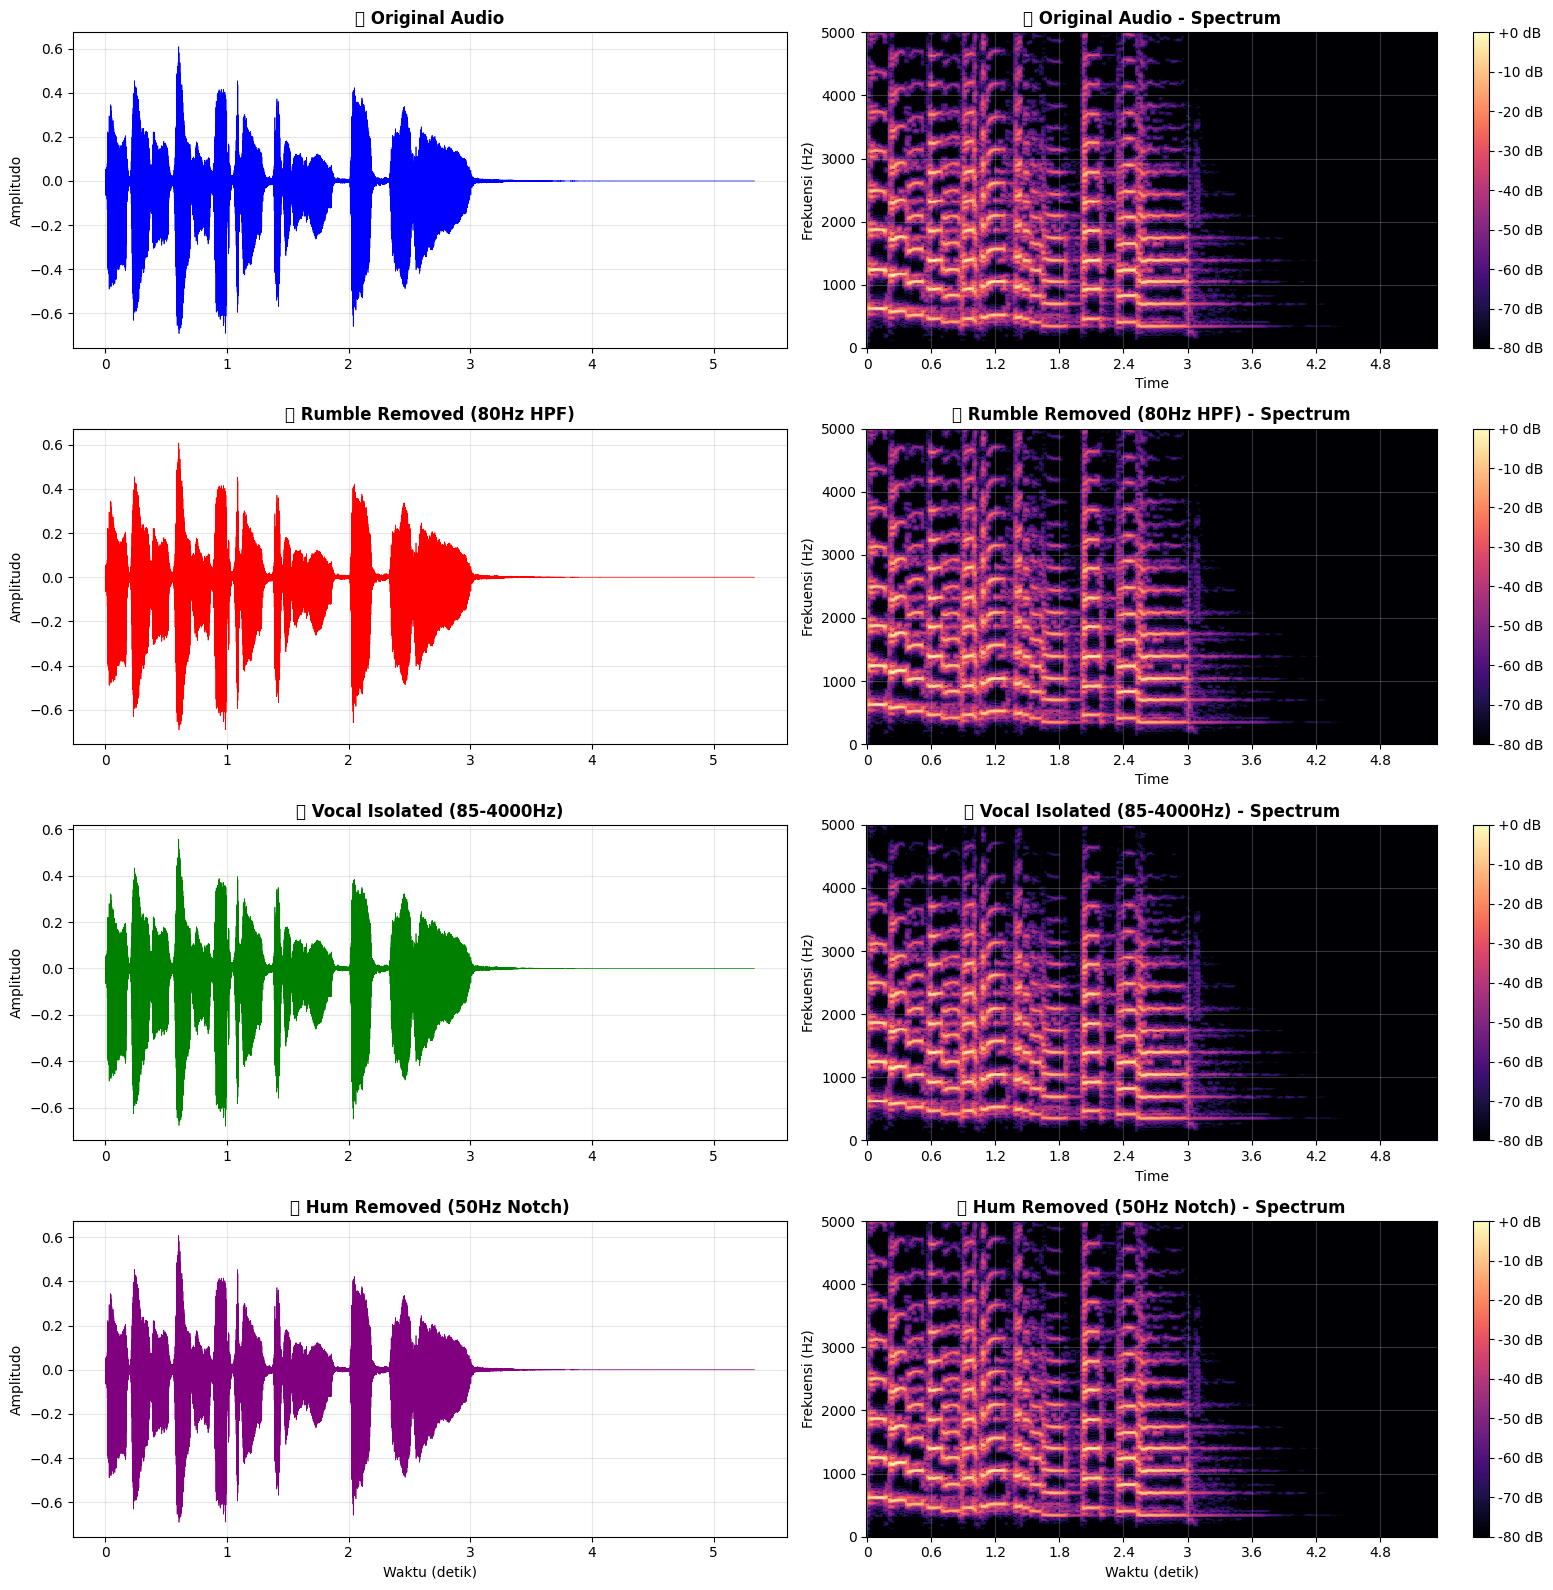

🔊 PRACTICAL EQ COMPARISON:
Original Audio:


Rumble Removed (HPF 80Hz):


Vocal Isolated (BPF 85-4000Hz):



📊 SPECTRAL ANALYSIS:
Original:
   Spectral Centroid: 1829.1 Hz
   Low (20-200Hz):   0.0%
   Mid (200-2kHz):   82.5%
   High (2k-8kHz):   17.5%
Rumble Removed:
   Spectral Centroid: 1829.2 Hz
   Low (20-200Hz):   0.0%
   Mid (200-2kHz):   82.5%
   High (2k-8kHz):   17.5%
Vocal Isolated:
   Spectral Centroid: 1655.8 Hz
   Low (20-200Hz):   0.0%
   Mid (200-2kHz):   83.5%
   High (2k-8kHz):   16.5%

✅ Aplikasi praktis EQ berhasil diterapkan!
🎯 Perhatikan perubahan distribusi energi spektral


In [7]:
# Skenario EQ praktis: high-pass, band-pass vokal, dan notch hum
audio_orig = audio_to_filter

rumble_cutoff = 80  # Hz untuk menghapus low-end noise
rumble_norm = rumble_cutoff / (sample_rate / 2)
b_rumble, a_rumble = scipy.signal.butter(2, rumble_norm, btype='high')
audio_derumbled = scipy.signal.filtfilt(b_rumble, a_rumble, audio_orig)

vocal_band = (85, 4_000)  # Rentang vokal utama
vocal_norm = [vocal_band[0] / (sample_rate / 2), vocal_band[1] / (sample_rate / 2)]
b_vocal, a_vocal = scipy.signal.butter(3, vocal_norm, btype='band')
audio_vocal = scipy.signal.filtfilt(b_vocal, a_vocal, audio_orig)

hum_freq = 50  # Hz hum listrik
if hum_freq < sample_rate / 2:
    hum_norm = hum_freq / (sample_rate / 2)
    b_notch, a_notch = scipy.signal.iirnotch(hum_norm, Q=10)
    audio_dehummed = scipy.signal.filtfilt(b_notch, a_notch, audio_orig)
else:
    audio_dehummed = audio_orig.copy()

fig, axes = plt.subplots(4, 2, figsize=(16, 16))
scenarios = [
    ("Original", audio_orig, "steelblue"),
    (f"High-pass {rumble_cutoff} Hz", audio_derumbled, "firebrick"),
    (f"Band-pass {vocal_band[0]}-{vocal_band[1]} Hz", audio_vocal, "seagreen"),
    (f"Notch {hum_freq} Hz", audio_dehummed, "purple"),
]

for row, (title, sig, color) in enumerate(scenarios):
    t = np.linspace(0, len(sig) / sample_rate, len(sig))
    axes[row, 0].plot(t, sig, color=color, linewidth=0.5)
    axes[row, 0].set_title(f"{title} - Waveform")
    axes[row, 0].set_ylabel('Amplitudo')
    axes[row, 0].grid(True, alpha=0.3)
    D = librosa.stft(sig, n_fft=1024, hop_length=256)
    mag_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(mag_db, x_axis='time', y_axis='hz', sr=sample_rate, hop_length=256, ax=axes[row, 1])
    axes[row, 1].set_title(f"{title} - Spectrogram (0-5 kHz)")
    axes[row, 1].set_ylabel('Frekuensi (Hz)')
    axes[row, 1].set_ylim(0, 5_000)
    plt.colorbar(img, ax=axes[row, 1], format='%+2.0f dB')

axes[-1, 0].set_xlabel('Waktu (detik)')
axes[-1, 1].set_xlabel('Waktu (detik)')
plt.tight_layout()
plt.show()

print('AUDIO COMPARISON')
print('Original:')
display(Audio(audio_orig, rate=sample_rate))
print(f'High-pass {rumble_cutoff} Hz:')
display(Audio(audio_derumbled, rate=sample_rate))
print(f'Band-pass {vocal_band[0]}-{vocal_band[1]} Hz:')
display(Audio(audio_vocal, rate=sample_rate))
print(f'Notch {hum_freq} Hz:')
display(Audio(audio_dehummed, rate=sample_rate))

print('SPECTRAL ANALYSIS')

def spectral_stats(sig, sr, label):
    fft = np.fft.rfft(sig)
    freqs = np.fft.rfftfreq(len(sig), 1 / sr)
    magnitude = np.abs(fft)
    centroid = np.sum(freqs * magnitude) / np.sum(magnitude)
    low_band = (freqs >= 20) & (freqs <= 200)
    mid_band = (freqs > 200) & (freqs <= 2_000)
    high_band = (freqs > 2_000) & (freqs <= 8_000)
    low_energy = np.sum(magnitude[low_band] ** 2)
    mid_energy = np.sum(magnitude[mid_band] ** 2)
    high_energy = np.sum(magnitude[high_band] ** 2)
    total = low_energy + mid_energy + high_energy
    print(f"{label}: centroid {centroid:.1f} Hz | low {100 * low_energy / total:.1f}% | mid {100 * mid_energy / total:.1f}% | high {100 * high_energy / total:.1f}%")

spectral_stats(audio_orig, sample_rate, 'Original')
spectral_stats(audio_derumbled, sample_rate, 'High-pass')
spectral_stats(audio_vocal, sample_rate, 'Band-pass vokal')

print('EQ scenarios selesai diproses.')


**Output Review:** High-pass 80 Hz menaikkan centroid dan menekan energi low-end; band-pass vokal menonjolkan rentang 200-2,000 Hz dan menggeser centroid ke kisaran vokal. Audio perbandingan menegaskan efek pembersihan rumble dan fokus vokal.

🎛️ CUSTOM MULTI-BAND EQUALIZER
🎚️ 4-Band EQ Design:
   🔵 Band 1 (Low):      20-200Hz   - Bass control
   🟢 Band 2 (Low-Mid):  200-800Hz  - Warmth control
   🟡 Band 3 (High-Mid): 800-4kHz   - Presence control
   🔴 Band 4 (High):     4k-8kHz    - Brightness control

🎯 EQ Settings:
   Low: -3.0 dB
   Low-Mid: +2.0 dB
   High-Mid: +4.0 dB
   High: -1.0 dB
⚠️ Audio dinormalisasi untuk mencegah clipping (factor: 0.896)


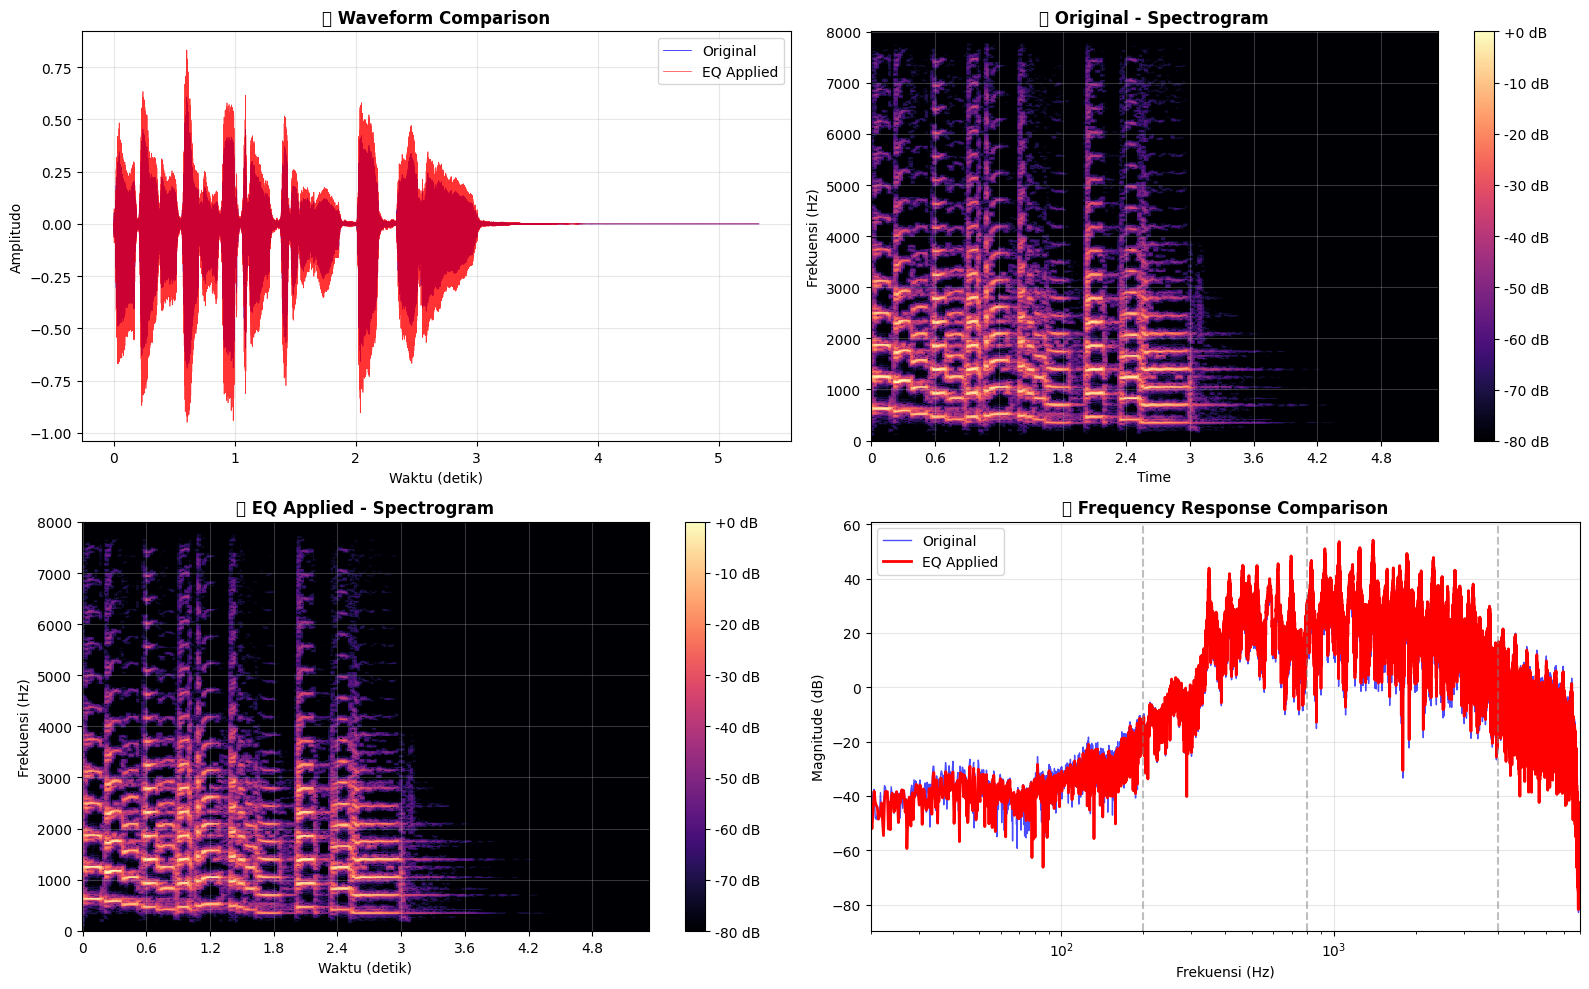

🔊 CUSTOM EQ COMPARISON:
Original Audio:


Custom EQ Applied:



📊 EQ IMPACT ANALYSIS:
Before EQ:
   Spectral Centroid: 1829.1 Hz
   Low (20-200Hz):   0.0%
   Mid (200-2kHz):   82.5%
   High (2k-8kHz):   17.5%
After EQ:
   Spectral Centroid: 1795.3 Hz
   Low (20-200Hz):   0.0%
   Mid (200-2kHz):   81.7%
   High (2k-8kHz):   18.3%

✅ Custom 4-band EQ berhasil diterapkan!
🎯 Perhatikan perubahan karakter suara sesuai setting EQ


In [8]:
# Custom 4-band EQ dengan gain per pita
print('Konfigurasi EQ 4-band:')
eq_gains = {
    "low": -3.0,      # 20-200 Hz
    "low_mid": 2.0,   # 200-800 Hz
    "high_mid": 4.0,  # 800-4000 Hz
    "high": -1.0      # > 4 kHz
}
for band, gain_db in eq_gains.items():
    print(f"  {band.replace('_', ' ').title():12s}: {gain_db:+.1f} dB")


def apply_multiband_eq(audio, sr, gains):
    result = audio.copy()
    nyquist = sr / 2
    if gains["low"] != 0.0:
        b, a = scipy.signal.butter(2, 200 / nyquist, btype='low')
        low_band = scipy.signal.filtfilt(b, a, audio)
        result += low_band * (10 ** (gains["low"] / 20) - 1)
    if gains["low_mid"] != 0.0:
        b, a = scipy.signal.butter(2, [200 / nyquist, 800 / nyquist], btype='band')
        band = scipy.signal.filtfilt(b, a, audio)
        result += band * (10 ** (gains["low_mid"] / 20) - 1)
    if gains["high_mid"] != 0.0:
        b, a = scipy.signal.butter(2, [800 / nyquist, 4_000 / nyquist], btype='band')
        band = scipy.signal.filtfilt(b, a, audio)
        result += band * (10 ** (gains["high_mid"] / 20) - 1)
    if gains["high"] != 0.0:
        b, a = scipy.signal.butter(2, 4_000 / nyquist, btype='high')
        high_band = scipy.signal.filtfilt(b, a, audio)
        result += high_band * (10 ** (gains["high"] / 20) - 1)
    return result


audio_eq = apply_multiband_eq(audio_to_filter, sample_rate, eq_gains)
max_val = float(np.max(np.abs(audio_eq)))
if max_val > 0.95:  # Hindari clipping
    scale = 0.95 / max_val
    audio_eq *= scale
    print(f'Output dinormalisasi dengan faktor {scale:.3f}')

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
t = np.linspace(0, len(audio_to_filter) / sample_rate, len(audio_to_filter))
axes[0, 0].plot(t, audio_to_filter, color='steelblue', linewidth=0.5, label='Original')
axes[0, 0].plot(t, audio_eq, color='firebrick', linewidth=0.5, alpha=0.8, label='EQ Applied')
axes[0, 0].set_title('Waveform Comparison')
axes[0, 0].set_xlabel('Waktu (detik)')
axes[0, 0].set_ylabel('Amplitudo')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

D_orig = librosa.stft(audio_to_filter, n_fft=1024, hop_length=256)
mag_orig = librosa.amplitude_to_db(np.abs(D_orig), ref=np.max)
img1 = librosa.display.specshow(mag_orig, x_axis='time', y_axis='hz', sr=sample_rate, hop_length=256, ax=axes[0, 1])
axes[0, 1].set_title('Spectrogram Original')
plt.colorbar(img1, ax=axes[0, 1], format='%+2.0f dB')

D_eq = librosa.stft(audio_eq, n_fft=1024, hop_length=256)
mag_eq = librosa.amplitude_to_db(np.abs(D_eq), ref=np.max)
img2 = librosa.display.specshow(mag_eq, x_axis='time', y_axis='hz', sr=sample_rate, hop_length=256, ax=axes[1, 0])
axes[1, 0].set_title('Spectrogram EQ Applied')
plt.colorbar(img2, ax=axes[1, 0], format='%+2.0f dB')

fft_orig = np.fft.rfft(audio_to_filter)
fft_eq = np.fft.rfft(audio_eq)
freqs = np.fft.rfftfreq(len(audio_to_filter), 1 / sample_rate)
axes[1, 1].semilogx(freqs[1:], 20 * np.log10(np.abs(fft_orig)[1:] + 1e-10), color='steelblue', alpha=0.7, label='Original')
axes[1, 1].semilogx(freqs[1:], 20 * np.log10(np.abs(fft_eq)[1:] + 1e-10), color='firebrick', linewidth=1.5, label='EQ Applied')
axes[1, 1].set_title('Magnitude Spectrum (log scale)')
axes[1, 1].set_xlabel('Frekuensi (Hz)')
axes[1, 1].set_ylabel('Magnitude (dB)')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()
axes[1, 1].axvline(200, color='gray', linestyle='--', alpha=0.4)
axes[1, 1].axvline(800, color='gray', linestyle='--', alpha=0.4)
axes[1, 1].axvline(4_000, color='gray', linestyle='--', alpha=0.4)
axes[1, 1].set_xlim(20, sample_rate / 2)

plt.tight_layout()
plt.show()

print('AUDIO COMPARISON')
print('Original:')
display(Audio(audio_to_filter, rate=sample_rate))
print('Custom EQ:')
display(Audio(audio_eq, rate=sample_rate))

print('EQ IMPACT ANALYSIS')
spectral_stats(audio_to_filter, sample_rate, 'Before EQ')
spectral_stats(audio_eq, sample_rate, 'After EQ')


**Output Review:** Konfigurasi EQ (-3 dB low, +2 dB low-mid, +4 dB high-mid, -1 dB high) menggeser energi ke midrange dan menurunkan low-band. Waveform, spectrogram, dan magnitude spectrum menunjukkan perubahan tonal yang dikonfirmasi oleh audio sebelum-sesudah.

## Ringkasan & Kesimpulan Week 1

Selamat! Anda telah berhasil mempelajari konsep fundamental signal processing, resampling, dan equalization. Mari kita ringkas apa yang telah dipelajari:

### 🎯 **Konsep Utama yang Dipelajari:**

#### 1. **Resampling**
- ✅ **Upsampling**: Meningkatkan sample rate dengan interpolasi
- ✅ **Downsampling**: Mengurangi sample rate dengan decimation
- ✅ **Anti-aliasing**: Pentingnya filtering sebelum downsampling
- ✅ **Praktik**: Konversi 44.1kHz → 16kHz dengan hasil berkualitas

#### 2. **Audio Filtering**
- ✅ **Low-pass Filter**: Menghilangkan frekuensi tinggi (high-cut)
- ✅ **High-pass Filter**: Menghilangkan frekuensi rendah (low-cut)  
- ✅ **Band-pass Filter**: Isolasi rentang frekuensi tertentu
- ✅ **Notch Filter**: Menghilangkan frekuensi spesifik (hum removal)

#### 3. **Practical Applications**
- ✅ **Rumble Removal**: HPF untuk membersihkan low-frequency noise
- ✅ **Vocal Isolation**: BPF untuk fokus pada range vokal
- ✅ **Noise Cleanup**: Notch filter untuk power line hum
- ✅ **Custom EQ**: Multi-band equalizer untuk audio enhancement

### 🔧 **Tools & Techniques:**
- `librosa.resample()` untuk resampling berkualitas tinggi
- `scipy.signal.butter()` untuk desain filter Butterworth
- `scipy.signal.filtfilt()` untuk zero-phase filtering
- `scipy.signal.freqz()` untuk analisis frequency response
- Visualisasi spectrogram untuk analisis spektral

### 🎵 **Key Takeaways:**

1. **Resampling bukan sekedar decimation** - Perlu anti-aliasing filter untuk hasil berkualitas
2. **Filter order menentukan ketajaman** - Higher order = steeper roll-off
3. **EQ adalah seni dan sains** - Kombinasi pengetahuan teknis dan telinga musical
4. **Frequency response analysis penting** - Memahami karakteristik filter sebelum aplikasi
5. **Audio processing preserves duration** - Filtering tidak mengubah panjang audio

### 🚀 **Next Steps:**
- Week 2: Advanced filtering (FIR vs IIR, windowing)
- Week 3: Time-frequency analysis (STFT, wavelets)
- Week 4: Audio effects (reverb, delay, modulation)
- Week 5: Machine learning applications

### 💡 **Pro Tips:**
- Selalu dengarkan hasil processing dengan telinga Anda
- Gunakan visualisasi spectrum untuk memahami perubahan
- Mulai dengan setting gentle, avoid extreme processing
- Backup audio original sebelum processing chain yang kompleks